## Deep Learning Project Part2

   * Images have been preprocessed on Part1
   * We will load the data and start evaluating it
   * We will define all our methods necessary
   * Create the Model
   * Train the Model
   * Show predictions and accuracy results
   * Show a Confusion Matrix of the results
   * Show picture examples of incorrect and correct images
   * Show a plot of Validations vs Losses

## Preprocessors

In [1]:
#Preprocessors used
from __future__ import absolute_import
from __future__ import print_function
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from datetime import timedelta
from keras import regularizers
import tensorflow as tf
import seaborn as sns
import numpy as np
import h5py
import time
import os

Using TensorFlow backend.


## Import and load the data

In [2]:
# default figure size for images
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0) 

h5f = h5py.File('SVHN_grey.h5', 'r')

# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
y_val = h5f['y_val'][:]

h5f.close()

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (63733, 32, 32, 1) (63733, 10)
Validation set (9524, 32, 32, 1) (9524, 10)
Test set (26032, 32, 32, 1) (26032, 10)


## Defined Methods

In [3]:
def get_batch(X, y, batch_size=512):
    for i in np.arange(0, y.shape[0], batch_size):
        end = min(X.shape[0], i + batch_size)
        yield(X[i:end],y[i:end])

In [4]:
def plot_images(images, nrows, ncols, cls_true, mode=None):
    # Initialize the subplotgrid
    fig, axes = plt.subplots(nrows, ncols)
    
    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    print("T = True, P = Prediction")
    for i, ax in zip(rs, axes.flat): 
        
        if mode is None:
            title = "T: {0}".format(np.argmax(cls_true[i]))
        
        else:
            title = "T: {0}, P: {1}".format(np.argmax(cls_true[i]), mode[i])  
            
        # Display the image
        ax.imshow(images[i,:,:,0], cmap='binary')
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])

In [5]:
def model(features):
    weight_decay = 2e-4
    
# INPUT->[CONV->RELU->CONV->RELU->POOL]->DROPOUT->[FC->RELU]->FC
    input_layer = tf.reshape(features, [-1, 32, 32, 1], name='Reshaped_Input')

    conv1 = tf.layers.conv2d( inputs=input_layer, filters=32,  
        kernel_size=[5, 5], padding="same", 
        kernel_regularizer=regularizers.l2(weight_decay),
        activation=tf.nn.relu)
    
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], 
            strides=2)

    conv2 = tf.layers.conv2d( inputs=pool1,filters=64, 
            kernel_size=[5, 5], padding="same", 
            kernel_regularizer=regularizers.l2(weight_decay),
            activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], 
            strides=2)
    
    pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=256, 
            activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.8)

    logits = tf.layers.dense(inputs=dropout, units=10)

    return logits

## Building the Model

In [6]:
max_epochs = 10
num_examples = X_train.shape[0]

In [7]:
# Method to flatten results for Confusion Matrix
def flatten(lists):
    flat = []
    for numbers in lists:
        for x in numbers:
            flat.append(x)
    return np.asarray(flat)

In [8]:
tf.logging.set_verbosity(tf.logging.INFO)

# Our application logic will be added here
x = tf.placeholder(tf.float32, shape = [None, 32, 32, 1], name='Input_Data')
y = tf.placeholder(tf.float32, shape = [None, 10], name='Input_Labels')
y_cls = tf.argmax(y, 1)

discard_rate = tf.placeholder(tf.float32, name='Discard_rate')
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [9]:
#with tf.name_scope('Model Prediction'):
prediction = model(x)
prediction_cls = tf.argmax(prediction, 1)
#with tf.name_scope('loss'):
loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=y, logits=prediction))

optimizer = tf.train.AdamOptimizer().minimize(loss)

W1203 17:09:33.333313  1888 deprecation.py:323] From <ipython-input-5-36aa2b28cf27>:9: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W1203 17:09:33.336306  1888 deprecation.py:506] From C:\Users\jguim\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1203 17:09:33.514797  1888 deprecation.py:323] From <ipython-input-5-36aa2b28cf27>:11: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W1203 17:09:33.645449  1888 deprecation.py:323] From <ipython-input-5-36aa2b28cf27>:20

In [10]:
# Predicted class equals the true class of each image?
correct_prediction = tf.equal(prediction_cls, y_cls)

# Cast predictions to float and calculate the mean
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [11]:
sess = tf.Session()

In [12]:
sess.run(tf.global_variables_initializer())

In [13]:
batch_size = 512
toss = 0.6
accu = 0.0

In [14]:
train_loss = []
valid_loss = []
start_time = time.time()
for epoch in range(max_epochs):
    print ('Training .........')
    epoch_loss = 0
    print ()
    print ('Epoch ', epoch+1 , ': ........ \n')
    step = 0   
    
    ## Training epochs ....
    for (epoch_x , epoch_y) in get_batch(X_train, y_train, batch_size):
        _, train_accu, c = sess.run([optimizer, accuracy, loss], 
        feed_dict={x: epoch_x, y: epoch_y, discard_rate: toss})
        train_loss.append(c)
    
        if(step%40 == 0):
            print ("Step:", step, ".....", "\nMini-Batch Loss   : ", c)
            print('Mini-Batch Accuracy :' , train_accu*100.0, '%')

            ## Validating prediction and summaries
            accu = 0.0
            for (epoch_x , epoch_y) in get_batch(X_val, y_val, 512):                            
                correct, _c = sess.run([correct_prediction, loss], feed_dict={x: epoch_x, y: epoch_y, discard_rate: toss})
                valid_loss.append(_c)
                accu+= np.sum(correct[correct == True])
            print('Validation Accuracy :' , accu*100.0/y_val.shape[0], '%')
            print ()
        step = step + 1


    print ('Epoch', epoch+1, 'completed out of ', max_epochs)

    
# Calculate net time
time_diff = time.time() - start_time

# Testing prediction and summaries

for (epoch_x , epoch_y) in get_batch(X_test, y_test, 512):
    correct = sess.run([correct_prediction], 
    feed_dict={x: epoch_x, y: epoch_y, discard_rate: toss})
    accu+= np.sum(correct[correct == True])
    
print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))
print ("\n\n")

Training .........

Epoch  1 : ........ 

Step: 0 ..... 
Mini-Batch Loss   :  2.2923074
Mini-Batch Accuracy : 10.3515625 %
Validation Accuracy : 18.805123897522048 %

Step: 40 ..... 
Mini-Batch Loss   :  1.782479
Mini-Batch Accuracy : 40.4296875 %
Validation Accuracy : 45.821083578328434 %

Step: 80 ..... 
Mini-Batch Loss   :  0.7607352
Mini-Batch Accuracy : 76.3671875 %
Validation Accuracy : 73.20453590928182 %

Step: 120 ..... 
Mini-Batch Loss   :  0.6001504
Mini-Batch Accuracy : 81.4453125 %
Validation Accuracy : 81.52036959260815 %

Epoch 1 completed out of  10
Training .........

Epoch  2 : ........ 

Step: 0 ..... 
Mini-Batch Loss   :  0.6248303
Mini-Batch Accuracy : 82.2265625 %
Validation Accuracy : 80.19739605207896 %

Step: 40 ..... 
Mini-Batch Loss   :  0.4610431
Mini-Batch Accuracy : 87.3046875 %
Validation Accuracy : 83.57832843343134 %

Step: 80 ..... 
Mini-Batch Loss   :  0.46562552
Mini-Batch Accuracy : 86.328125 %
Validation Accuracy : 84.79630407391852 %

Step: 120 ..

## Model Visualization

T = True, P = Prediction


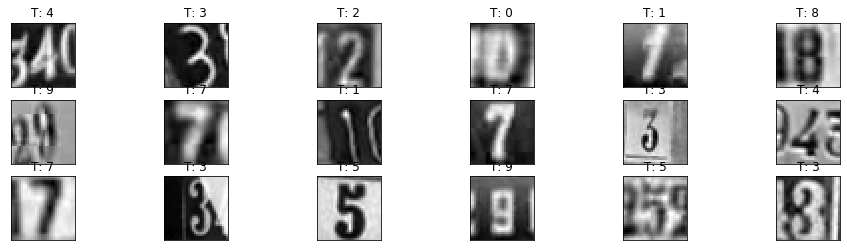

In [15]:
plot_images(X_train, 3, 6, y_train);

In [16]:
test_pred = []
for (epoch_x , epoch_y) in get_batch(X_test, y_test, 512):
    correct = sess.run([prediction_cls], 
    feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
    test_pred.append((np.asarray(correct, dtype=int)).T)

## Confusion Matrix

In [17]:
flat_array = flatten(test_pred)
flat_array = (flat_array.T)
flat_array = flat_array[0]
flat_array.shape

(26032,)

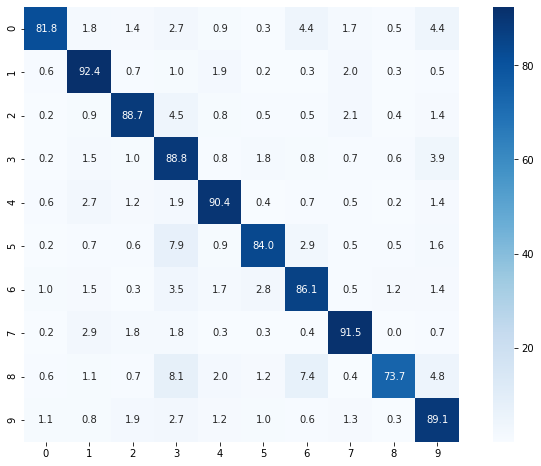

In [18]:
#Set the figure size
plt.figure(figsize=(12, 8))

#Calculate the confusion matrix
cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=flat_array)

#Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

#Show
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.1f', square=True);

## Classified picture examples
    First set of images are incorrect examples
    Second set of images are correct examples

T = True, P = Prediction


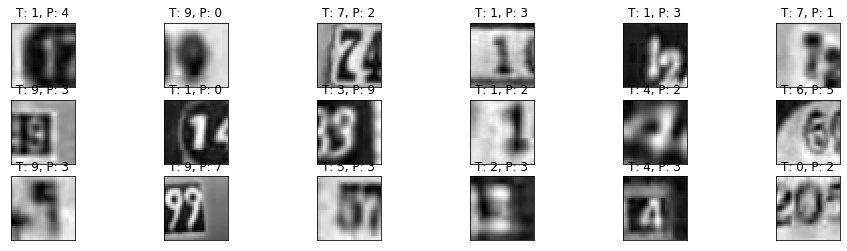

In [19]:
# Find incorrectly classified examples
incorrect = flat_array != np.argmax(y_test, axis=1)

images = X_test[incorrect]
cls_true = y_test[incorrect]
mode = flat_array[incorrect]

plot_images(images, 3, 6, cls_true, mode);

T = True, P = Prediction


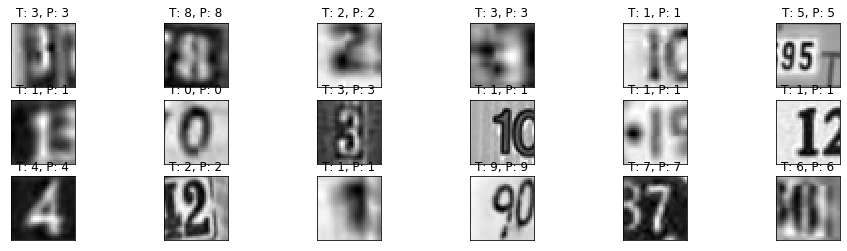

In [20]:
# Find correctly classified examples
correct = np.invert(incorrect)

images = X_test[correct]
cls_true = y_test[correct]
mode = flat_array[correct]

plot_images(images, 3, 6, cls_true, mode);

## Plot Validatiosn vs Losses

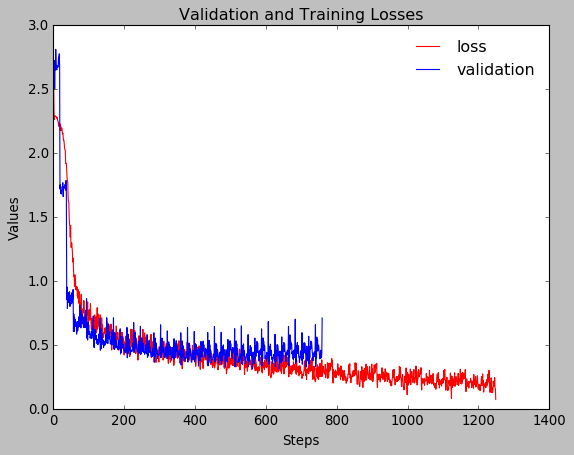

In [21]:
plt.style.use('classic')
plt.title("Validation and Training Losses")
plt.xlabel("Steps")
plt.ylabel("Values")
plt.plot(train_loss ,'r', label = 'loss')
plt.plot(valid_loss, 'b', label = 'validation')
plt.legend(loc='upper right', frameon=False)

## Final Comments:

Project was achieved with an accuracy of 88.6% using 10 epochs
A much higher accuracy can be achieved by adding more epochs but..
    That would require higher computational power and time.